In [1]:
import math
import geopandas as gpd
# import osmnx as ox
import numpy as np
import urllib.request
from time import sleep
import json
import pyproj
import matplotlib.pyplot as plt

### TODO: identify neighbouring states and consider block groups in these states as potentially walkable.

# Find the BGs within 15 minutes walking distance of every BG

In [8]:
def get_haversine_distance(point_1, point_2):
    """
    Calculate the distance between any 2 points on earth given as [lon, lat]
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [point_1[0], point_1[1], 
                                                point_2[0], point_2[1]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371000 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def getOSRMDirections(mode, start_lon, start_lat, end_lon, end_lat):
    str_ll='{},{};{},{}'.format(start_lon, start_lat, end_lon, end_lat)
    try:
        with urllib.request.urlopen('http://router.project-osrm.org/route/v1/'+str(mode)+'/'+str_ll+'?overview=false') as url:
            data=json.loads(url.read().decode())
            #in meters and seconds
        return data['routes']
        # if the call request is unsuccessful, wait and try again
    except:
        print('Sleeping')
        sleep(10)
        routes=getOSRMDirections(mode, start_lon, start_lat, end_lon, end_lat)
        return routes
    
def get_OSRM_matrix(mode, str_coords_comb, str_dest_nums):
    query='http://router.project-osrm.org/table/v1/{}/{}?sources=0&destinations={}&annotations=distance,duration'.format(mode, str_coords_comb, str_dest_nums)
    try:
        with urllib.request.urlopen(query) as url:
            data=json.loads(url.read().decode())
            #in meters and seconds
        return data
        # if the call request is unsuccessful, wait and try again
    except:
        print('Sleeping')
        sleep(10)
        data=get_OSRM_matrix(mode, str_coords_comb, str_dest_nums)
        return data

In [3]:
year=2017
state_fips='11'
bg=gpd.read_file('https://www2.census.gov/geo/tiger/TIGER{}/BG/tl_{}_{}_bg.zip'.format(year, year, state_fips))

<AxesSubplot:>

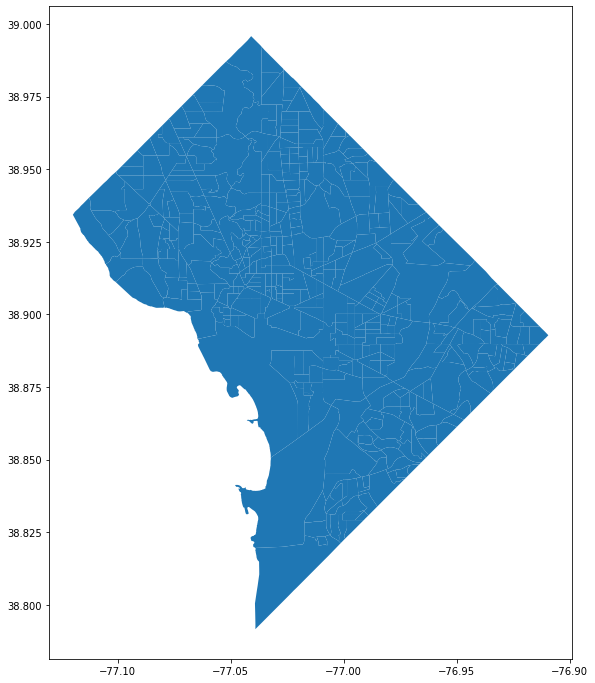

In [4]:
fig, ax=plt.subplots(1, figsize=(12,12))
bg.plot(ax=ax)

In [5]:
len(bg)

450

### Get straight line distances between every pair of BGs in order to rule out some pairs as walkable

In [9]:
def get_lon_lat_centroid(polygon_row):
    centroid=polygon_row.geometry.centroid
    return [centroid.x, centroid.y]

In [10]:
bg['centroid_lon_lat']=bg.apply(lambda row: get_lon_lat_centroid(row), axis=1)

In [11]:
straight_dist_mat=np.zeros((len(bg), len(bg)))

In [12]:
centroids=bg['centroid_lon_lat']
geoid_order=bg['GEOID']

In [13]:
for i in range(len(bg)):
# for i in range(100):
    if i%1000==0:
        print(i)
    straight_dist_mat[i, i]=0
    point_1=centroids[i]
    for j in range(i+1, len(bg)):
        point_2=centroids[j]
        dist=get_haversine_distance(point_1, point_2)
        straight_dist_mat[i, j]=dist
        straight_dist_mat[j, i]=dist   

0


### Get the distances to the potentially walkable BGs using matrix requests

If the straight line distance is greater than the max distance its impossible for the walking distance to be less <br>
Assume further that if the straight line distance is less than 30% of the max distance, then the walking distance will be less. This will cut down on API requests.

In [28]:
bg_to_walkable_bg={}

In [14]:
max_walk_dist=1200
# straight_line_prop=0.3

In [30]:
for i in range(len(bg)):
# for i in range(100):
    if i%1000==0:
        print(i)
        json.dump(bg_to_walkable_bg, open('../outputs/walkable_bg/bg_to_walkable_bg_osrm_{}.json'.format(state_fips), 'w'))
    ind_bg_to_check=np.where((straight_dist_mat[i, :]<max_walk_dist))[0]
#     ind_bg_assume_walkable=np.where(straight_dist_mat[i, :]<max_walk_dist*straight_line_prop)[0]
    str_source_coords='{},{}'.format(centroids[i][0], centroids[i][1])
    list_str_dest_coords=['{},{}'.format(centroids[j][0], centroids[j][1]) for j in ind_bg_to_check]
    str_coords_comb=';'.join([str_source_coords]+list_str_dest_coords)
    str_dest_nums=';'.join([str(i) for i in range(1,len(list_str_dest_coords)+1)])
    # get durations from API                            
    data=get_OSRM_matrix('walking', str_coords_comb, str_dest_nums)
    distances=data['distances'][0]
    ind_bg_walkable=[ind_bg_to_check[i] for i in range(len(distances)) if distances[i]<1200]
    bg_to_walkable_bg[geoid_order[i]]=[geoid_order[iw] for iw in ind_bg_walkable]
json.dump(bg_to_walkable_bg, open('../outputs/walkable_bg/bg_to_walkable_bg_osrm_{}.json'.format(state_fips), 'w'))

0


# Check results with a few block groups

In [6]:
bg_to_walkable_bg=json.load(open('../outputs/walkable_bg/bg_to_walkable_bg_osrm_{}.json'.format(state_fips)))

In [15]:
import random
centre_block=random.choice([bg for bg in bg_to_walkable_bg])
# centre_block='250259901010'
print(bg_to_walkable_bg[centre_block])
bg_shp_center=bg.loc[bg['GEOID']==centre_block]
bg_shp_reachable=bg.loc[bg['GEOID'].isin(bg_to_walkable_bg[centre_block])]

# get bg centroids within 5km
ind_center=list(bg['GEOID']).index(centre_block)
ind_within_1200m=np.where(straight_dist_mat[ind_center, :]<1200)[0]
ind_within_5km=np.where(straight_dist_mat[ind_center, :]<5000)[0]

['110010036002', '110010037003', '110010038001', '110010038002', '110010043001', '110010044001', '110010028021', '110010037002', '110010036001', '110010037001', '110010039003', '110010036003', '110010038003']


In [18]:
import folium
%matplotlib inline

center_centroid=bg_shp_center.geometry.centroid

m = folium.Map([bg_shp_center.geometry.centroid.iloc[0].y, bg_shp_center.geometry.centroid.iloc[0].x], zoom_start=10, tiles='cartodbpositron')
folium.GeoJson(bg_shp_center, style_function=lambda feature: {'color': 'red','fillColor': 'red'}).add_to(m)
folium.GeoJson(bg_shp_reachable, style_function=lambda feature: {'color': 'blue','fillColor': 'blue'}).add_to(m)

for i_c in ind_within_5km:
    folium.Circle(
    radius=5,
    location=[centroids[i_c][1], centroids[i_c][0]],
    fill=False,
    color='black'
    ).add_to(m)
m

for i_c in ind_within_1200m:
    folium.Circle(
    radius=20,
    location=[centroids[i_c][1], centroids[i_c][0]],
    fill=False,
    color='yellow'
    ).add_to(m)
m

<ipython-input-18-a6ec6547fd0c>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_centroid=bg_shp_center.geometry.centroid
<ipython-input-18-a6ec6547fd0c>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map([bg_shp_center.geometry.centroid.iloc[0].y, bg_shp_center.geometry.centroid.iloc[0].x], zoom_start=10, tiles='cartodbpositron')
